In [296]:
%reset -f

In [297]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
import math as math
from scipy.integrate import solve_ivp
from scipy.integrate import quad 
import scipy.optimize as optimize 

## Energy Balance Reboiler

#df_Me = pd.read_excel(r'/Users/caterina/Documents/TU:e/CPT/Process Tech/python intro/Cp_methanol.xlsx')
#df_Iso = pd.read_excel(r'/Users/caterina/Documents/TU:e/CPT/Process Tech/python intro/Cp_isopropanol.xlsx')


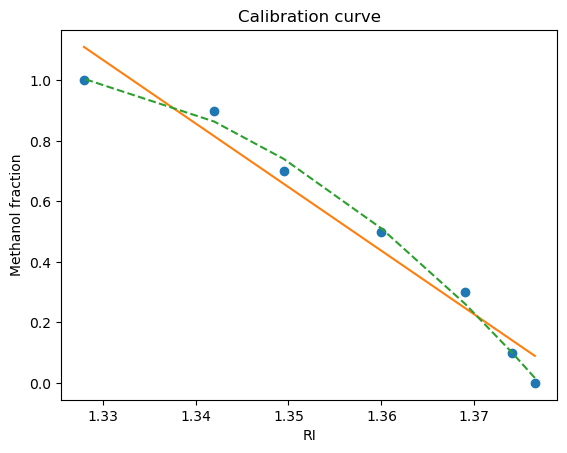

0.5105995532418319


In [298]:
# Refractive Index Calibration Curve

#Measurements
Me_fraction = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
RI = [1.3765, 1.374, 1.369, 1.360, 1.3495, 1.342, 1.328]

#fitting line at multiple degrees
Cal_a_fit, Cal_b_fit = np.polyfit(RI, Me_fraction, deg=1)
Cal_a_fit2, Cal_b_fit2, Cal_c_fit2 = np.polyfit(RI, Me_fraction, deg=2)

plt.plot(RI, Me_fraction,"o")
plt.plot(RI, np.polyval((Cal_a_fit, Cal_b_fit), RI),"-")
plt.plot(RI, np.polyval((Cal_a_fit2, Cal_b_fit2, Cal_c_fit2), RI), "--")
plt.xlabel("RI")
plt.ylabel("Methanol fraction")
plt.title('Calibration curve')
plt.show()

def Calibration(RI):
    Me_ratio = RI**2 * Cal_a_fit2 + RI*Cal_b_fit2 + Cal_c_fit2
    return Me_ratio

#use calibration function to get the methanol fraction
Me_frac = Calibration(1.36)
print(Me_frac)

In [299]:
#Constants 

R = 8.3144598    # Gas constant J/molK
g = 9.807        # Gravitational acceleration m/s^2

# Reboiler info and trey
A_r = 0.08                  # Evaporation surface area m2
dH_vap_Me = 37340        # Enthalpy of vaporisation methanol at boiling point [J/mol]
dH_vap_iso = 44000
eff = 1 #640/751         # Heater efficiency (around 0.85)
T0 = 298                 #K
V  = 0.01                # Volume of mixture in reboiler [m^3]
Iso_frac = 1-Me_frac     # Mole fraction isopropanol
dens_Me = 792     #g/dm3
dens_Iso = 786    #g/dm3
dens_mix_L = ((792+786)/2)  #g/dm3
M_Me = 32.02             #g/mol
M_Iso = 60.1             #g/mol
Vm_Me = 40.75            # molar volume methanol [cm^3/mol]
Vm = (M_Me/1000/dens_Me)*Me_frac + (M_Iso/1000/dens_Iso)*(1-Me_frac) # Molar volume of mixture [m^3/mol]
n_total = V/Vm           # Total number of moles in mixture
n_Me = Me_frac*n_total   # Number of moles of methanol
n_Iso = Iso_frac*n_total # Number of moles of isopropanol
power_percent = 0.7
power = eff*power_percent*2000      #J/s (maximum power is 2kW)
A_tray = 0.001963495408493621   #surface area of one tray in m2
lw =  0.025                      #length weir in m 
#A_weir = 
How = 0.005                      #height over outlet weir in m  
dp = 547.7                       #pressure drop over entire column in Pa
x_iso_in = 0.5                   #Isopropanol fraction inlet
x_me_in = 0.5                    #Methanol fraction inlet
RR = 0.2                         #Reflux ratio

In [300]:
(0.005*A_tray*dens_mix_L*1000)/(45)

0.17213309747794076

In [301]:
#Heat transfer coefficients 

Cp_L_me = 87.71   #J/mol.K
Cp_v_me = 47.99   #J/mol.K
Cp_L_iso = 176.16 #J/mol.K
Cp_v_iso = 110.29 #J/mol.K

#Heat transfer coefficients 

Cp_L_me = 87.71   #J/mol.K
Cp_v_me = 47.99   #J/mol.K
Cp_L_iso = 176.16 #J/mol.K
Cp_v_iso = 110.29 #J/mol.K

#Total liquid avg heat transfer coeff in J/mol.K
def Cp_L(x_me, x_iso):
    Cp_L = x_me*Cp_L_me + x_iso*Cp_L_iso
    return Cp_L

#Total vapor avg heat transfer coeff in J/mol.K
def Cp_v(y_me, y_iso):
    Cp_v = y_me*Cp_v_me + y_iso*Cp_v_iso
    return Cp_v

#Total (liquid+vapor) avg heat transfer coeff in J/mol.K
def Cp_tot(Nme_L,Niso_L,Nme_v,Niso_v):
    x_me = Nme_L/(Nme_L+Niso_L+Nme_v+Niso_v)
    x_iso = Niso_L/(Nme_L+Niso_L+Nme_v+Niso_v)
    y_me = Nme_v/(Nme_L+Niso_L+Nme_v+Niso_v)
    y_iso = Niso_v/(Nme_L+Niso_L+Nme_v+Niso_v)
    Cp_tot = x_me*Cp_L_me + x_iso*Cp_L_iso + y_me*Cp_v_me + y_iso*Cp_v_iso
    return Cp_tot


# Vapor pressure for both compounds in Pa 
def p0_me(T):
    #Antonie constants-methanol 
    A_me = 8.08097
    B_me = 1582.27
    C_me = 239.7
    #vapour pressure
    anto_me = A_me - (B_me/(T+C_me))
    p0_me_mmHg = math.pow(10,anto_me) 
    p0_me = p0_me_mmHg/0.00750062   #Pa

    return p0_me   


def p0_iso(T):
    #Antoine constants isopropanol
    A_iso = 8.00308
    B_iso =	1505.52
    C_iso = 211.6
    #vapour pressure 
    anto_iso = A_iso - (B_iso/(T+C_iso))
    p0_iso_mmHg = math.pow(10,anto_iso)
    p0_iso = p0_iso_mmHg/0.00750062   #Pa
    
    return p0_iso


In [302]:
k_me = 1.34  #m/s 
k_iso = 1.27 #m/s


In [303]:
params = {
    'R': R,          # Gas constant
    'k_me': k_me,    # mass coefficient methanol,
    'k_iso': k_iso,  # mass coefficient isopropanol
    'A_r': A_r,      #evaporation surface area of reboiler 
    'A_tray': A_tray,#evaporation surface area of each tray 
    'dens_mix_L': dens_mix_L,  #density of mixture 
    'M_Me': M_Me,
    'M_Iso': M_Iso,
    'lw': lw,
    'How': How,
    'x_me_in': x_me_in,
    'x_iso_in': x_iso_in,
    'dH_vap_Me': dH_vap_Me,
    'dH_vap_iso': dH_vap_iso,  
    'power': power 
}

In [304]:
def modelODE(t,N, params):
    
    R = params['R']
    k_me = params['k_me']
    k_iso = params['k_iso']
    A_r = params['A_r']
    A_tray = params['A_tray']
    dens_mix_L = params['dens_mix_L']
    M_Me = params['M_Me']
    M_Iso = params['M_Iso']
    lw = params['lw']
    How = params['How']
    x_me_in = params['x_me_in']
    x_iso_in = params['x_iso_in']



    T_ref = 298.15
    Q_cool = 104 
    T_cool = 293.15
    T_tray = 337.8
    A_a = ((0.05*0.01)**2) * math.pi #area of 1 hole in the top of a tray->throough which vapor goes out 

    Nme_LR = N[0]
    Niso_LR = N[1]
    Nme_vR = N[2]
    Niso_vR = N[3]
    N_L_totR = Nme_LR+Niso_LR
    N_v_totR = Nme_vR+Niso_vR

    T = N[4]

    Nme_L_tray = N[5]
    Niso_L_tray = N[6]
    Nme_v_tray = N[7]
    Niso_v_tray = N[8]
    N_L_tot_tray = Nme_L_tray+Niso_L_tray
    N_v_tot_tray = Nme_v_tray+Niso_v_tray




    #mol fractions reboiler
    y_meR = Nme_vR/N_v_totR
    x_meR = Nme_LR/N_L_totR
    y_isoR = Niso_vR/N_v_totR
    x_isoR = Niso_LR/N_L_totR

    #mol fractions tray
    y_me_tray = Nme_v_tray/N_v_tot_tray
    x_me_tray = Nme_L_tray /N_v_tot_tray
    y_iso_tray = Niso_v_tray /N_v_tot_tray
    x_iso_tray = Niso_L_tray /N_L_tot_tray

    
    dNdt = np.zeros(9)

    #p_tot = y_me*p0_me(T) + y_iso*p0_iso(T)
    p_tot = 101325
    p_tot_tray = p_tot-dp/9

    Vm_me = M_Me/1000/dens_Me
    Vm_iso = M_Iso/1000/dens_Iso
    Vm_L = (Nme_LR/N_L_totR) * Vm_me * (Niso_LR/N_L_totR) * Vm_iso
    V_R = N_L_totR * Vm_L




    if (Nme_LR>0 and Niso_LR>0 and Nme_L_tray>0 and Niso_L_tray>0 and Nme_vR>0 and Niso_vR>0 and Nme_v_tray>0 and Niso_v_tray>0):

        evap_me = 0.00002*A_r * ((x_meR*p0_me(T) - p_tot*y_meR)/(R*T))
        evap_iso = 0.00002*A_r * ((x_isoR*p0_iso(T) - p_tot*y_isoR)/(R*T))
        evap_tray_me = 0.000001*A_tray * ((x_me_tray*p0_me(T_tray) - p_tot_tray*y_me_tray)/(R*T_tray))
        evap_tray_iso = 0.000001*A_tray * ((x_iso_tray*p0_iso(T_tray) - p_tot_tray*y_iso_tray)/(R*T_tray))

        L_inflow = 2 * (1/3600) * dens_mix_L/(x_me_in*M_Me + x_iso_in*M_Iso)
        #CONDENSER
        #steady state enthaly balance 
        #V_tray = (dens_mix_L/(x_me_tray*M_Me + x_iso_tray*M_Iso)) * 10*A_a* 0.00001  * math.sqrt((dp/8)/dens_mix_L)
        #L_condenser = V_tray
        L_condenser = Q_cool/(Cp_v(y_me_tray,y_iso_tray)*(T_tray-T_ref) + dH_vap_Me + dH_vap_iso - Cp_L(y_me_tray,y_iso_tray)*(T_cool-T_ref))
        V_tray = L_condenser
        M_holdup = (A_tray*How*dens_mix_L*1000)/(0.5*M_Me+0.5*M_Iso)
        Hol = ((Nme_L_tray+Niso_L_tray)*(x_me_tray*M_Me+x_iso_tray*M_Iso))/(dens_mix_L*A_tray)
        L_weir = (1.8385*lw*(Hol-How))/1000
       
        #steady-state ethalpy balance
        
        H_F = L_inflow* Cp_L(x_me_in,x_iso_in)*(T_tray-T_ref) #Enthalpy of feed liquid entering the tray
        H_L = L_condenser*Cp_L(y_me_tray,y_iso_tray)*(T_cool-T_ref) #Enthalpy of condenser liquid entering the tray
        H_V = V_tray*(Cp_v(y_me_tray,y_iso_tray)*(T_tray-T_ref)+(y_meR*dH_vap_Me + y_isoR*dH_vap_iso)) #Enthalpy of vapor leaving the tray
        H_W = L_weir*Cp_L(x_me_tray,x_iso_tray)*(T_tray-T_ref) #Enthalpy of liquid leaving the tray
        V_reboiler = -1*((H_L - H_W + H_F +H_V)/(Cp_v(y_meR,y_isoR)*(T-T_ref)+(y_meR*dH_vap_Me + y_isoR*dH_vap_iso)))
        H_R = V_reboiler*(Cp_v(y_meR,y_isoR)*(T-T_ref)+(y_meR*dH_vap_Me + y_isoR*dH_vap_iso))#Enthalpy of vapor leaving the reboiler

        #REBOILER 
        #liquid methanol 
        dNdt[0] = L_weir*x_me_tray - evap_me
        #liquid isopropanol 
        dNdt[1] = L_weir*x_iso_tray - evap_iso
        #vapor methanol
        dNdt[2] = evap_me - V_reboiler*y_meR
        #vapor isopropano
        dNdt[3] = evap_iso -V_reboiler*y_isoR
        #temperature equation 
        dNdt[4] = (power + H_W - H_R)/(Cp_tot(Nme_LR,Niso_LR,Nme_vR,Niso_vR)*(N_L_totR+N_v_totR))
    
        #TRAY
        #liquid methanol
        dNdt[5] = L_inflow*x_me_in + L_condenser*y_me_tray - evap_tray_me
        #liquid isopropanol
        dNdt[6] = L_inflow*x_iso_in + L_condenser*y_iso_tray - evap_tray_iso
        #vapor methanol
        dNdt[7] = V_reboiler*y_meR + evap_tray_me - V_tray*y_me_tray
        #vapor isopropanol
        dNdt[8] = V_reboiler*y_isoR + evap_tray_iso - V_tray*y_iso_tray
        print(V_reboiler,L_inflow,L_weir, evap_me,evap_iso,V_tray)
    elif Nme_LR <= 0 or Niso_LR <= 0 or Nme_vR <= 0 or Niso_vR <=0 or  Nme_L_tray <= 0 or Niso_L_tray <= 0 or Nme_v_tray <= 0 or Niso_v_tray <= 0:
        dNdt[0] = 0
        dNdt[1] = 0
        dNdt[2] = 0
        dNdt[3] = 0
        dNdt[4] = 0
        dNdt[5] = 0
        dNdt[6] = 0
        dNdt[7] = 0
        dNdt[8] = 0
    
    

    return dNdt

In [305]:
#M_holdup = (A_tray*How*dens_mix_L)/(0.5*M_Me+0.5*M_Iso)
#(M_holdup/(dens_mix_L*A_tray*0.8))
#print(math.pow(((M_holdup/(dens_mix_L*A_tray))),(3/2)))
#L_weir = math.pow(((((M_holdup/(dens_mix_L*A_tray))-How)/(1.41))),(3/2))*dens_mix_L*lw*60
#L_weir

In [306]:
N_initial = [115, 115, 1, 1, 293, 1, 1, 1, 1] # meL isoL meV isoV
#tspan = np.linspace(0, 10000, 10000)
t0, tf = 0, 10000
sol = solve_ivp(modelODE, (t0, tf), N_initial,args = (params,), method='Radau')
#N = odeint(modelODE, N_initial, tspan, args = (params,))


-0.002190504491724501 0.0095165725864814 0.002732839708209181 0.005615805725751955 0.004545826787218927 0.001221552279101768
-0.0021808269531147337 0.0095165725864814 0.0027872823662858314 0.005622360970375217 0.004551775615479728 0.0012215523239737023
-0.002190504491724501 0.0095165725864814 0.002732839708209181 0.005615805683663031 0.004545826821335887 0.001221552279101768
-0.002190504491724501 0.0095165725864814 0.002732839708209181 0.005615805767840878 0.004545826753101967 0.001221552279101768
-0.002190504492256559 0.0095165725864814 0.002732839708209181 0.0056158057255040455 0.004545826787466838 0.001221552279101768
-0.0021905044911924433 0.0095165725864814 0.002732839708209181 0.005615805725999866 0.004545826786971016 0.001221552279101768
-0.002190504472925795 0.0095165725864814 0.002732839708209181 0.005615805958732218 0.004545826991673029 0.001221552279101768
-0.002190504488973041 0.0095165725864814 0.002732839729443065 0.005615805725751955 0.004545826787218927 0.00122155227910

In [307]:
print(sol.y[7], sol.y[6])

[ 1.          0.99961943  0.99581765  0.95823904  0.71234762  0.67524462
  0.70696921  0.79632663  1.18846531  1.60613569  2.64641654  4.97768196
 10.49456611 24.41002845 48.73017708 57.11855552] [ 1.          1.00120308  1.01323386  1.13354236  2.13585378  2.60670676
  3.07723592  3.54716946  4.79362989  5.83139348  7.98573634 11.80427376
 18.63296698 31.27392309 48.19230192 53.31292728]


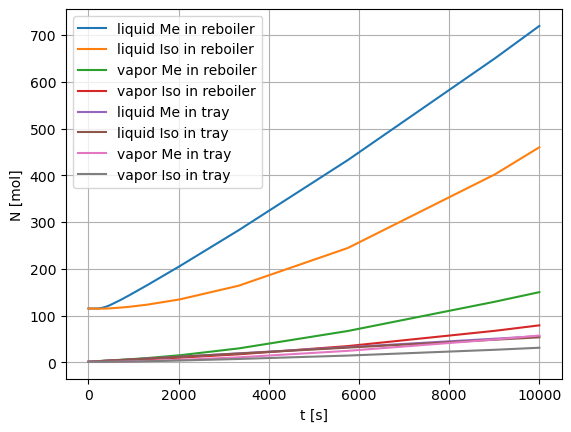

In [308]:
#plt.plot(tspan, N[:,0], label = 'liquid Me')
#plt.plot(tspan, N[:,1], label = 'liquid Iso')
#plt.plot(tspan, N[:,2], label = 'vapor Me')
#plt.plot(tspan, N[:,3], label = 'vapor Iso')

plt.plot(sol.t, sol.y[0], label = 'liquid Me in reboiler')
plt.plot(sol.t, sol.y[1], label = 'liquid Iso in reboiler')
plt.plot(sol.t, sol.y[2], label = 'vapor Me in reboiler')
plt.plot(sol.t, sol.y[3], label = 'vapor Iso in reboiler')
plt.plot(sol.t, sol.y[5], label = 'liquid Me in tray')
plt.plot(sol.t, sol.y[6], label = 'liquid Iso in tray')
plt.plot(sol.t, sol.y[7], label = 'vapor Me in tray')
plt.plot(sol.t, sol.y[8], label = 'vapor Iso in tray')

plt.legend()
plt.xlabel("t [s]")
plt.ylabel("N [mol]")
plt.grid()
plt.show()

In [309]:
30/1000

0.03

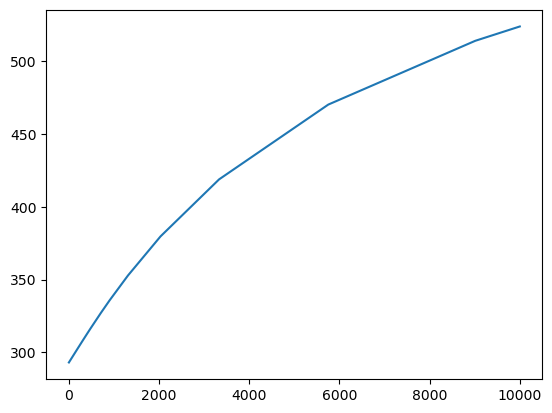

In [310]:
#plt.plot(tspan,N[:,4])
plt.plot(sol.t,sol.y[4])